In [1]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
clist = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
         '#ffff33', '#a65628', '#f781bf', '#999999']
prop_cycle = pl.cycler(color=clist)
lw_default = 4
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': lw_default,
    'font.size': 20,
    'figure.figsize': [13.333, 6.6],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

In [2]:
# Setup PowerPoint presentation
from pptx import Presentation
from pptx.util import Inches, Pt
pres = Presentation()
pres.slide_width = 12192000
title_slide_layout = pres.slide_layouts[0]
two_content_layout = pres.slide_layouts[3]
title_only_layout = pres.slide_layouts[5]
#title_only_layout.shapes[2].text_frame.paragraphs[0].font.size = Pt(40)
blank_layout = pres.slide_layouts[6]
title_only_layout.slide_master.shapes.element[2].cx = 11277600

slide = pres.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'Sunstone Presentation'
slide.placeholders[1].text = 'Quentin Spencer'

#slide = pres.slides.add_slide(two_content_layout)
#slide.shapes.title.text = 'Grace & Works'
#slide.placeholders[1].text = '\n'.join(sa_data['grace'])
#slide.placeholders[2].text = '\n'.join(sa_data['works'])


def create_ppt_slide(fname, title_str):
    '''Add figure slide to PowerPoint presentation'''
    full_filename = f'../presentation/{fname}.png'
    pl.savefig(full_filename)
    slide = pres.slides.add_slide(title_only_layout)
    slide.shapes.title.text = title_str
    pic = slide.shapes.add_picture(full_filename,
                                   Inches(0), Inches(1.0), height=Inches(6.5))
    # Move picture behind title
    cursor_sp = slide.shapes[0]._element
    cursor_sp.addprevious(pic._element)
    print('added {0:s} to presentation'.format(full_filename))

In [3]:
import sys
sys.path.append('../')
from data_utils import *

md = load_membership_data()
td = load_temple_data()

# deal with cases where no groundbreaking is listed, because groundbreaking date is used later
missing_gr = td['Groundbreaking date'].isna() & ~td['Dedication date'].isna()
td.loc[missing_gr, 'Groundbreaking date'] = td[missing_gr]['Dedication date'] - np.timedelta64(3, 'Y')

# for this analysis, exclude temple temples that won't be built
exclude = ['Efforts halted in 1830s', 'Efforts suspended in 2006', 'Historic site', 'Destroyed']
td = td[~td['Status'].isin(exclude)]

In [4]:
most_common_size_count = td.value_counts('area').iloc[0]

# Area categories
td['area_cat'] = ''
td.loc[td['area']>0, 'area_cat'] = '0-12000'
td.loc[td['area']>12000, 'area_cat'] = '12000-20000'
td.loc[td['area']>20000, 'area_cat'] = '20000-30000'
td.loc[td['area']>30000, 'area_cat'] = '30000-40000'
td.loc[td['area']>40000, 'area_cat'] = '40000-50000'
td.loc[td['area']>50000, 'area_cat'] = '50000-70000'
td.loc[td['area']>70000, 'area_cat'] = '70000-100000'
td.loc[td['area']>100000, 'area_cat'] = '100000+'

# Dedication decade
td['ded_dec'] = 'future'
td.loc[td['Dedication date'].dt.year>0, 'ded_dec'] = 'earlier'
td.loc[td['Dedication date'].dt.year>=1980, 'ded_dec'] = '1980s'
td.loc[td['Dedication date'].dt.year>=1990, 'ded_dec'] = '1990s'
td.loc[td['Dedication date'].dt.year>=2000, 'ded_dec'] = '2000s'
td.loc[td['Dedication date'].dt.year>=2010, 'ded_dec'] = '2010s'
td.loc[td['Dedication date'].dt.year>=2020, 'ded_dec'] = '2020s'

# region categories
td['reg_cat'] = 'non-US'
td.loc[td['Country']=='United States', 'reg_cat'] = 'other US'
td.loc[td['Region'].isin(['Utah', 'Idaho', 'Arizona']), 'reg_cat'] = 'UT/ID/AZ'

#td['area_cat'].value_counts().sort_index()
#td.value_counts('ded_dec').sort_index()
#td['reg2'].value_counts()

In [5]:
# For projecting future costs, estimate sizes of announced temples. Small, medium, and large
# temples are assigned to be 10,000, 20,000, and 30,000 square feet. Most of the temples are
# presumed to be small, including all of those in Europe and Asia. A few are presumed medium
# based on being near large population centers in countries with large church membership.
small_temple_list = [
    'Managua Nicaragua Temple',
    'Budapest Hungary Temple',
    'Dubai United Arab Emirates Temple',
    'Oslo Norway Temple',
    'Brussels Belgium Temple',
    'Vienna Austria Temple',
    'Singapore Republic of Singapore Temple',
    'Kaohsiung Taiwan Temple',
    'Tacloban City Philippines Temple',
    'Cagayan de Oro Philippines Temple',
    'Urdaneta Philippines Temple',
    'Alabang Philippines Temple',
    'Cody Wyoming Temple',
    'Culiacán Mexico Temple',
    'Vitória Brazil Temple',
    'Belém Brazil Temple',
    'Antananarivo Madagascar Temple',
    'Santa Cruz Bolivia Temple',
    'Lagos Nigeria Temple',
    'Benin City Nigeria Temple',
    'Kumasi Ghana Temple',
    'Beira Mozambique Temple',
    'Monrovia Liberia Temple',
    'Nairobi Kenya Temple',
    'Abidjan Ivory Coast Temple',
    'San Juan Puerto Rico Temple',
    'Kananga Democratic Republic of the Congo Temple',
    'Auckland New Zealand Temple'
]

medium_temple_list = [
    'Quito Ecuador Temple',
    'Lima Peru Los Olivos Temple',
    'Salta Argentina Temple',
    'São Paulo East Brazil Temple',
    'Santiago West Chile Temple',
    'Fort Worth Texas Temple',    
    'Rexburg North Idaho Temple',
    'Teton River Idaho Temple']

large_temple_list = [
    'La Paz Bolivia Temple']

even_larger_list = ['Heber Valley Utah Temple']

who_knows_if_it_will_get_built_list = [
    'Russia Temple',
    "Shanghai People's Republic of China Temple"]

# Check whether items need to be added or removed
combined_list = small_temple_list+medium_temple_list+large_temple_list+even_larger_list+ \
            who_knows_if_it_will_get_built_list
no_area = td['area'].isna()
in_lists = td['Name'].isin(combined_list)
to_add_to_lists = td[no_area & ~in_lists]['Name'].to_list()
to_remove_from_lists = td[in_lists & ~no_area]['Name'].to_list()

if len(to_add_to_lists):
    print('need to add to lists:')
    print(to_add_to_lists)

if len(to_remove_from_lists):
    print('need to remove from lists:')
    print(to_remove_from_lists)


td.loc[td['Name'].isin(small_temple_list), 'area'] = 10000
td.loc[td['Name'].isin(medium_temple_list), 'area'] = 20000
td.loc[td['Name'].isin(large_temple_list), 'area'] = 30000
td.loc[td['Name'].isin(even_larger_list), 'area'] = 40000

td['area_estimated'] = 0
td.loc[td['Name'].isin(small_temple_list+medium_temple_list+large_temple_list), 'area_estimated'] = 1

# estimate site size for temples that don't have lots yet.
# based on previous averages, small:3 acres, medium: 6 acres, large: 10 acres
lot_dict = {10000:3, 20000:6, 30000:10, 40000:10}
site_idx = td['site'].isna() & ~td['area'].isna()

td[site_idx][['Name', 'area', 'Announcement date']]
td['site_estimated'] = 0
td.loc[site_idx, 'site_estimated'] = 1

td.loc[site_idx, 'site'] = td[site_idx]['area'].replace(lot_dict)

added ../presentation/progress.png to presentation


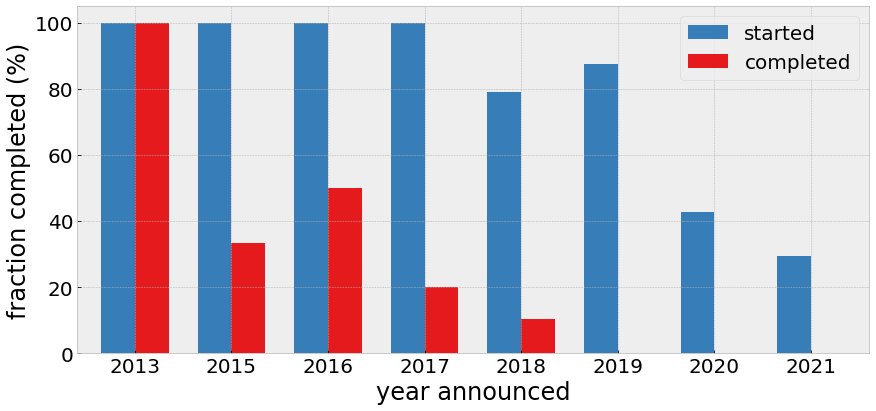

In [6]:
an_cmpl = td['Announcement date'].dt.year.to_frame('year announced').assign(
    started=(~td['Groundbreaking date'].isna()).astype(int).to_frame('started'),
    completed=(~td['Dedication date'].isna()).astype(int).to_frame('completed'))

plotdata = an_cmpl.groupby('year announced').mean()
ax = (plotdata[plotdata.index>=2013]*100).plot.bar(rot=0, width=0.7, ylabel='fraction completed (%)')

create_ppt_slide('progress', 'temple progress/completion by announcement year')

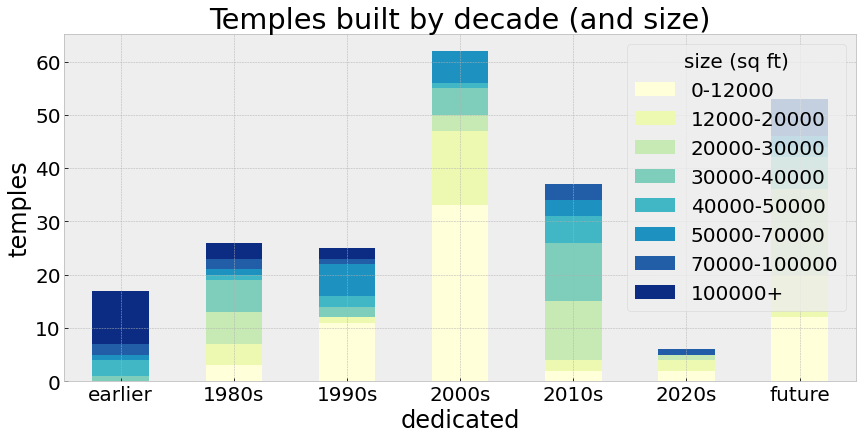

In [7]:
ded_size_table = td.groupby(['area_cat', 'ded_dec']).size().reset_index().pivot(
    columns='area_cat', index='ded_dec').fillna(0)
ded_size_table = ded_size_table.loc[
    ['earlier', '1980s', '1990s', '2000s', '2010s', '2020s', 'future']]
ded_size_table.columns = ded_size_table.columns.get_level_values(1)
ded_size_table = ded_size_table[
    ['0-12000', '12000-20000', '20000-30000', '30000-40000',
     '40000-50000', '50000-70000', '70000-100000', '100000+']]
ded_size_table.columns.name = 'size (sq ft)'

clist2 = ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb',
          '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']
mod_props = {'axes.prop_cycle': pl.cycler(color=clist2)}

with pl.rc_context(mod_props):
    _ = ded_size_table.plot.bar(stacked=True, rot=0,
                                ylabel='temples', xlabel='dedicated',
                                title='Temples built by decade (and size)')

The following is some analysis of the temple data found on this [Wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_temples_of_The_Church_of_Jesus_Christ_of_Latter-day_Saints). The data were extracted into a table using this [online tool](https://wikitable2csv.ggor.de/).

## Temple construction time

In [8]:
# Use temples completed since 2008 as a reference for estimating planning and construction time
# set minimum date for estimated grounbreaking and dedication so they aren't in the past
min_date = pd.to_datetime('2022-07-01')

ref_temples = td[(td['Announcement date'].dt.year>=2008) & (~td['Dedication date'].isna())]
est_times = ref_temples[['Announcement date', 'Groundbreaking date',
                         'Dedication date']].diff(axis=1).mean()

gr_est = td['Groundbreaking date'].isna()
td.loc[gr_est, 'Groundbreaking date'] = td[gr_est]['Announcement date'] + \
                                        est_times['Groundbreaking date']
idx = gr_est & (td['Groundbreaking date'] < min_date)
td.loc[idx, 'Groundbreaking date'] = min_date

de_est = td['Dedication date'].isna()
td.loc[de_est, 'Dedication date'] = td[de_est]['Groundbreaking date'] + \
                                    est_times['Dedication date']
idx = de_est & (td['Dedication date'] < min_date)
td.loc[idx, 'Dedication date'] = min_date

td['completion_estimated'] = 0
td.loc[de_est, 'completion_estimated'] = 1

## Size of temples over time

added ../presentation/temple_size_1870.png to presentation


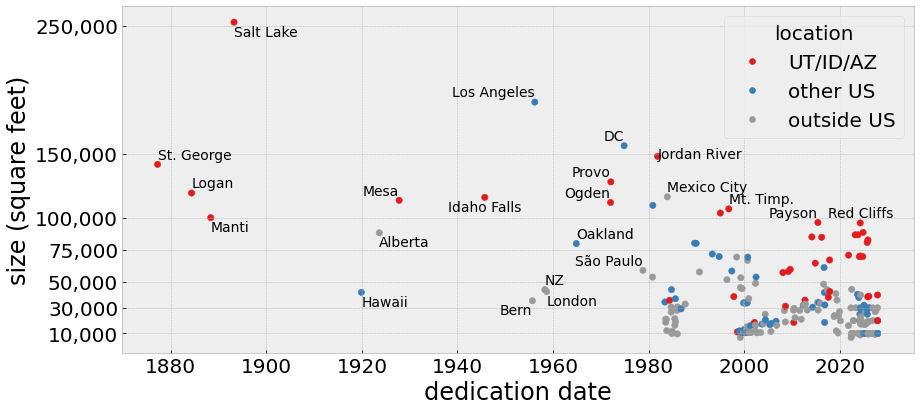

In [9]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap([clist[1], clist[0], clist[8]])

td_ = td[~td['area'].isna()]
idict = {'UT/ID/AZ': 0, 'other US': 1, 'non-US': 2}
idx = np.array([idict[r] for r in td_['reg_cat']])

sc = pl.scatter(td_['Dedication date'], td_['area'], c=idx, cmap=cmap, s=40)
pl.yticks([1e4,3e4,5e4,7.5e4,1e5,1.5e5, 2.5e5], ['10,000', '30,000', '50,000', '75,000',
                                                 '100,000', '150,000', '250,000'])
pl.ylabel('size (square feet)')
pl.xlabel('dedication date')
pl.legend(sc.legend_elements()[0], ['UT/ID/AZ', 'other US', 'outside US'], title='location')#, prop={'size': 18})

# Annotations
if True:
    labeldata = [
        ('St. George Utah Temple', 'St. George', 'left', 'bottom'),
        ('Salt Lake Temple', 'Salt Lake', 'left', 'top'),
        ('Manti Utah Temple', 'Manti', 'left', 'top'),
        ('Logan Utah Temple', 'Logan', 'left', 'bottom'),
        ('Laie Hawaii Temple', 'Hawaii', 'left', 'top'),
        ('Cardston Alberta Temple', 'Alberta', 'left', 'top'),
        ('Mesa Arizona Temple', 'Mesa', 'right', 'bottom'),
        ('Idaho Falls Idaho Temple', 'Idaho Falls', 'center', 'top'),
        ('Los Angeles California Temple', 'Los Angeles', 'right', 'bottom'),
        ('Bern Switzerland Temple', 'Bern', 'right', 'top'),
        ('London England Temple', 'London', 'left', 'top'),
        ('Hamilton New Zealand Temple', 'NZ', 'left', 'bottom'),
        ('Oakland California Temple', 'Oakland', 'left', 'bottom'),
        ('Jordan River Utah Temple', 'Jordan River', 'left', 'center'),
        ('Provo Utah Temple', 'Provo', 'right', 'bottom'),
        ('Ogden Utah Temple', 'Ogden', 'right', 'bottom'),
        ('Washington D.C. Temple', 'DC', 'right', 'bottom'),
        ('Mount Timpanogos Utah Temple', 'Mt. Timp.', 'left', 'bottom'),
        ('Payson Utah Temple', 'Payson', 'right', 'bottom'),
        ('Red Cliffs Utah Temple', 'Red Cliffs', 'center', 'bottom'),
        ('Mexico City Mexico Temple', 'Mexico City', 'left', 'bottom'),
        ('São Paulo Brazil Temple', 'São Paulo', 'right', 'bottom')]

    ax = pl.gca()
    for label, shortlabel, halign, valign in labeldata:
        data = td_[td_['Name']==label][['Dedication date', 'area']].iloc[0].copy()
        if valign=='top':
            data['area'] -= 2000
        else:
            data['area'] += 2000
        ax.annotate(shortlabel, data, size='x-small', ha=halign, va=valign)

create_ppt_slide('temple_size_1870', 'Size and dedication dates of temples built since 1870')

added ../presentation/temple_size_1950.png to presentation


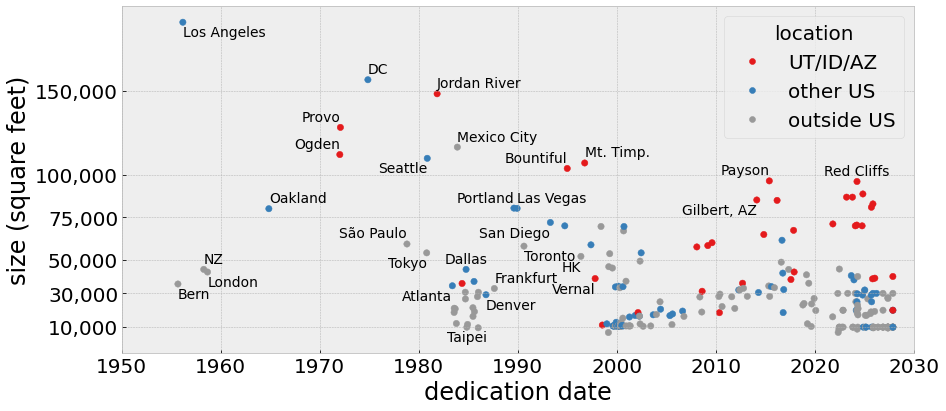

In [10]:
sc = pl.scatter(td_['Dedication date'], td_['area'], c=idx, cmap=cmap, s=40)
pl.yticks([1e4,3e4,5e4,7.5e4,1e5,1.5e5], ['10,000', '30,000', '50,000', '75,000', '100,000', '150,000'])
pl.ylabel('size (square feet)')
pl.xlabel('dedication date')
pl.xlim([pd.to_datetime('1950-01-01'), pd.to_datetime('2030-01-01')])
pl.ylim(ymax=200000)
pl.legend(sc.legend_elements()[0], ['UT/ID/AZ', 'other US', 'outside US'], title='location')

# Annotations
if True:
    labeldata = [
        ('Los Angeles California Temple', 'Los Angeles', 'left', 'top'),
        ('Bern Switzerland Temple', 'Bern', 'left', 'top'),
        ('London England Temple', 'London', 'left', 'top'),
        ('Hamilton New Zealand Temple', 'NZ', 'left', 'bottom'),
        ('Oakland California Temple', 'Oakland', 'left', 'bottom'),
        ('Jordan River Utah Temple', 'Jordan River', 'left', 'bottom'),
        ('Provo Utah Temple', 'Provo', 'right', 'bottom'),
        ('Ogden Utah Temple', 'Ogden', 'right', 'bottom'),
        ('Washington D.C. Temple', 'DC', 'left', 'bottom'),
        ('Bountiful Utah Temple', 'Bountiful', 'right', 'bottom'),
        ('Mount Timpanogos Utah Temple', 'Mt. Timp.', 'left', 'bottom'),
        ('Payson Utah Temple', 'Payson', 'right', 'bottom'),
        ('Red Cliffs Utah Temple', 'Red Cliffs', 'center', 'bottom'),
        ('Mexico City Mexico Temple', 'Mexico City', 'left', 'bottom'),
        ('Seattle Washington Temple', 'Seattle', 'right', 'top'),
        ('Dallas Texas Temple', 'Dallas', 'center', 'bottom'),
        ('Atlanta Georgia Temple', 'Atlanta', 'right', 'top'),
        ('Denver Colorado Temple', 'Denver', 'left', 'top'),
        ('Frankfurt Germany Temple', 'Frankfurt', 'left', 'bottom'),
        ('Portland Oregon Temple', 'Portland', 'right', 'bottom'),
        ('Las Vegas Nevada Temple', 'Las Vegas', 'left', 'bottom'),
        ('São Paulo Brazil Temple', 'São Paulo', 'right', 'bottom'),
        ('Tokyo Japan Temple', 'Tokyo', 'right', 'top'),
        ('Taipei Taiwan Temple', 'Taipei', 'center', 'top'),
        ('Toronto Ontario Temple', 'Toronto', 'left', 'top'),
        ('Vernal Utah Temple', 'Vernal', 'right', 'top'),
        ('San Diego California Temple', 'San Diego', 'right', 'top'),
        ('Hong Kong China Temple', 'HK', 'right', 'top'),
        ('Gilbert Arizona Temple', 'Gilbert, AZ', 'right', 'top')]

    ax = pl.gca()
    for label, shortlabel, halign, valign in labeldata:
        data = td_[td_['Name']==label][['Dedication date', 'area']].iloc[0].copy()
        if valign=='top':
            data['area'] -= 2000
        else:
            data['area'] += 2000
        ax.annotate(shortlabel, data, size='x-small', ha=halign, va=valign)

create_ppt_slide('temple_size_1950', 'Size and dedication dates of temples built since 1950')

added ../presentation/temple_size_1998.png to presentation


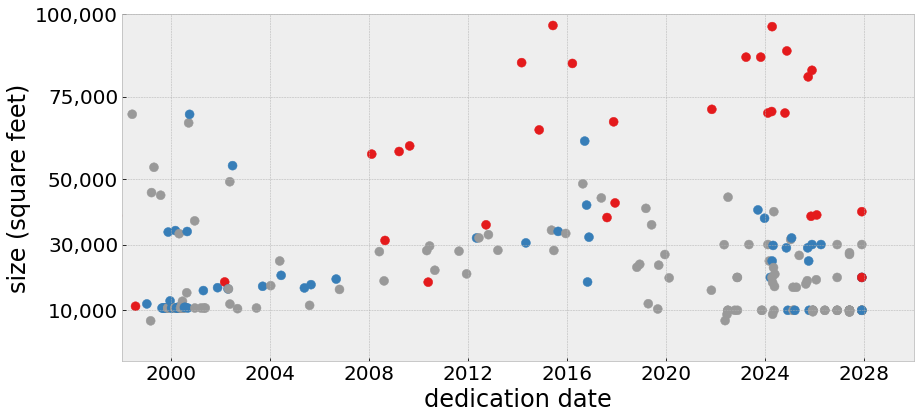

In [11]:
sc = pl.scatter(td_['Dedication date'], td_['area'], c=idx, cmap=cmap, s=80)
pl.yticks([1e4,3e4,5e4,7.5e4,1e5,1.5e5], ['10,000', '30,000', '50,000', '75,000', '100,000', '150,000'])
pl.ylabel('size (square feet)')
pl.xlabel('dedication date')
pl.xlim([pd.to_datetime('1998-01-01'), pd.to_datetime('2030-01-01')])
pl.ylim(ymax=100000)

create_ppt_slide('temple_size_1998', 'Size and dedication dates of temples built since 1998')

In [12]:
# calculate how many temples were using filmed endowment presentation
ef = td[['Name', 'Dedication date']].copy()
#ef['Dedication']<'1950-01-01'
film_era = ef['Dedication date']>'1950-01-01'
ef.loc[film_era, 'film_start'] = ef[film_era]['Dedication date']

conversion_dates = [
    ['St. George Utah Temple', '1975-11-11'],
    ['Logan Utah Temple', '1979-03-13'],
    ['Manti Utah Temple', '2025-01-01'],
    ['Salt Lake Temple', '2025-01-01'],
    ['Laie Hawaii Temple', '1978-06-13'],
    ['Cardston Alberta Temple', '1991-03-22'], # rededication date, seems later than the others
    ['Mesa Arizona Temple', '1975-04-16'],
    ['Idaho Falls Idaho Temple', '1975-01-01'] # no exact date on this one
]

for temple, date in conversion_dates:
    ef.loc[ef['Name']==temple, 'film_start'] = date
ef = ef.sort_values('Dedication date')
ef['total'] = np.arange(len(ef)) + 1
ef['film'] = 0
for idx, row in ef.iterrows():
    ef.loc[idx, 'film'] = (ef.loc[:idx, 'film_start']<=row['Dedication date']).sum()
ef['film_frac'] = ef['film']/ef['total']
#ef.plot(x='Dedication date', y='film_frac')

added ../presentation/temples_vs_time.png to presentation


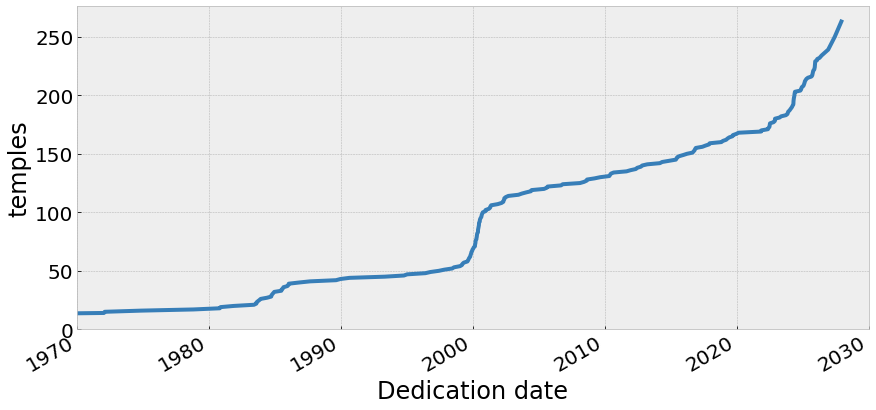

In [13]:
td_.groupby('Dedication date').size().sort_index().cumsum().plot(
    xlim=['1970-01-01', '2030-01-01'], ylim=[0, None],
    ylabel='temples')

create_ppt_slide('temples_vs_time', 'number of temples over time')

added ../presentation/temple_space_vs_time.png to presentation


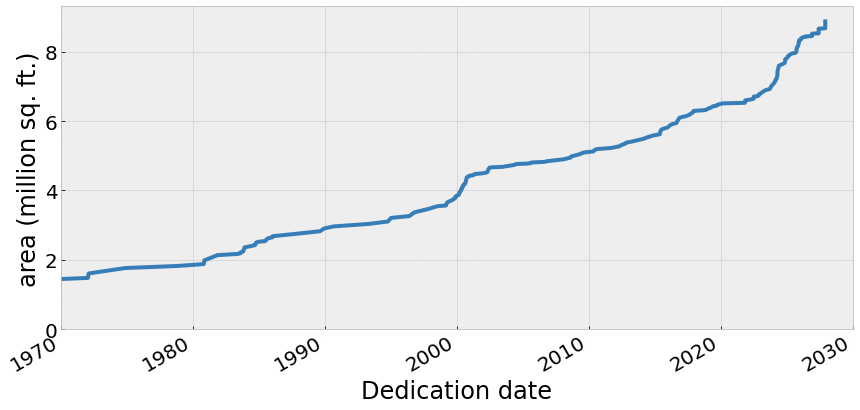

In [14]:
area_time = td_[['Dedication date','area']].sort_values('Dedication date')
area_time['total area (million sq ft)'] = area_time['area'].cumsum()/1e6
area_time['number'] = area_time.reset_index().index+1
area_time.plot(x='Dedication date', y=['total area (million sq ft)'],
               xlim=['1970-01-01', '2030-01-01'], ylim=[0, None],
               ylabel='area (million sq. ft.)', legend=False)

create_ppt_slide('temple_space_vs_time', 'total temple space over time')

In [15]:
area_time['year'] = area_time['Dedication date'].dt.year
year_end_vals = area_time.groupby('year')[['total area (million sq ft)', 'number']].max()

ym_tmp = year_end_vals.merge(
    md, left_index=True, right_on='Year', how='outer').sort_values('Year')
ym_tmp['date'] = pd.to_datetime(ym_tmp['Year'].apply(lambda x: f'{x+1}-01-01'))
# worst case growth: 0
last_idx = ym_tmp['Membership'].idxmax()
last_mem_val = ym_tmp.loc[last_idx]['Membership']
ym_tmp.loc[last_idx:, 'Membership (min)'] = last_mem_val
# best case growth: last 20 years
ref_mem_vals = ym_tmp[ym_tmp['Year'].between(2000,2021)]['Membership']
growth_factor = np.mean(ref_mem_vals.values[1:]/ref_mem_vals.values[:-1])
proj_years = ym_tmp.loc[last_idx:]['Year']
proj_mem = (last_mem_val * growth_factor**(proj_years - proj_years.iloc[0])).round(0)
ym_tmp.loc[last_idx:, 'Membership (max)'] = proj_mem

ym = ym_tmp[ym_tmp['Year']>=1877].copy()
ym['area'] = ym['total area (million sq ft)'].fillna(method='ffill')*1e6
ym['number'] = ym['number'].fillna(method='ffill').astype(int)

In [16]:
bg_shade = '#d7d7e7'
kimball_temples = ('1983-01-01', '1987-01-01')
hinckley_temples = ('1999-01-01', '2002-01-01')
nelson_temples = ('2022-01-01', '2029-07-01')
filmed_endowment_transition = (ef[ef['film_frac']<=0.2].iloc[-1]['Dedication date'],
                               ef[ef['film_frac']>=0.8].iloc[0]['Dedication date'])

def dateinterp(dates, r):
    a, b = [np.datetime64(val) for val in dates]
    return a + (b-a)*r

def add_bg(ax, bg='fkh', text=True, yval=0.05):
    y_pos = lambda y: np.inner(ax.get_ylim(), (1-y, y))
    if 'f' in bg:
        ax.axvspan(*filmed_endowment_transition, color='#d7f7d7')
        if text:
            ax.annotate('transition to\nfilmed\nendowment', ('1958-01-01', y_pos(0.05)),
                        size='x-small', ha='left', va='bottom')
    if 'k' in bg:
        ax.axvspan(*kimball_temples, color=bg_shade)
        if text:
            ax.annotate('Kimball surge',
                        (dateinterp(kimball_temples, 0.7), y_pos(0.05)),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'h' in bg:
        ax.axvspan(*hinckley_temples, color=bg_shade)
        if text:
            ax.annotate('Hinckley surge',
                        (dateinterp(hinckley_temples, 0.7), y_pos(0.05)),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'n' in bg:
        ax.axvspan(*nelson_temples, color=bg_shade, zorder=0)
        if text:
            ax.annotate('Nelson surge',
                        (dateinterp(nelson_temples, 0.7), y_pos(yval)),
                        size='x-small', ha='right', va='bottom', rotation=90)

added ../presentation/filmed_endowment.png to presentation
added ../presentation/members_per_temple.png to presentation
added ../presentation/members_per_sq_ft.png to presentation


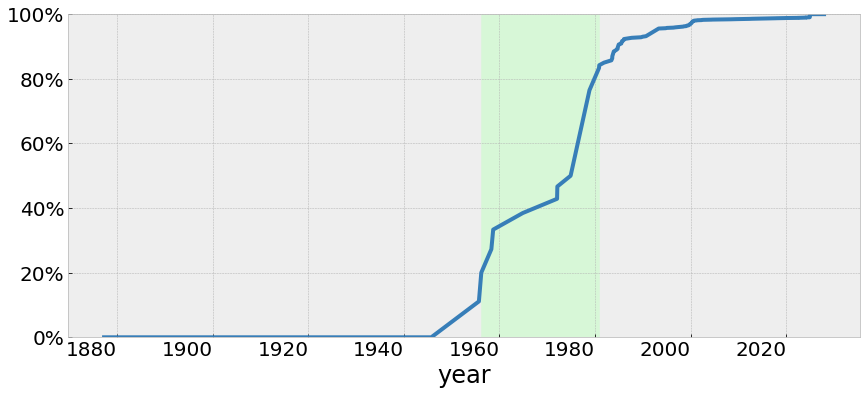

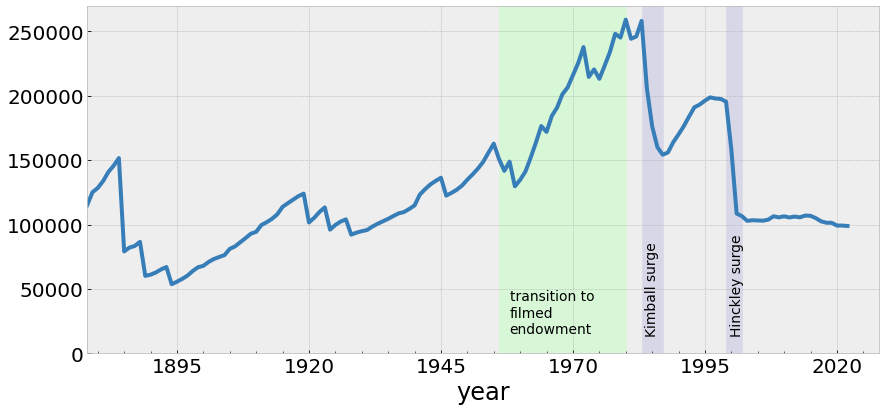

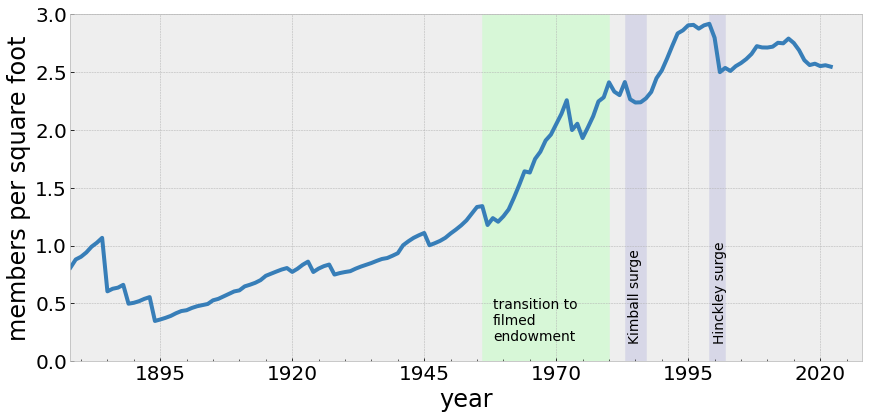

In [17]:
ax1 = ef.plot(x='Dedication date', y='film_frac', ylim=[0, 1],
              xlabel='year',
              yticks=np.linspace(0, 1, 6),
              legend=False,
              rot=0)
ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
add_bg(ax1, 'f', False)
create_ppt_slide('filmed_endowment', 'the transition to the filmed endowment presentation')

m_t = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['number'], 0)
m_t.index = ym['date']
m_t.columns = ['historical', 'projected (min)', 'projected (max)']
ax2 = m_t[['historical']].plot(xlabel='year', ylim=[0, None], legend=False)
add_bg(ax2)
create_ppt_slide('members_per_temple', 'church membership per temple over time')

m_a = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['area'], 0)
m_a.index = ym['date']
m_a.columns = ['historical', 'projected (min)', 'projected (max)']
ax3 = m_a[['historical']].plot(ylabel='members per square foot', xlabel='year', ylim=[0, 3], legend=False)
add_bg(ax3)
create_ppt_slide('members_per_sq_ft', 'church membership per square foot of temple over time')

added ../presentation/members_per_temple2.png to presentation
added ../presentation/members_per_sq_ft2.png to presentation


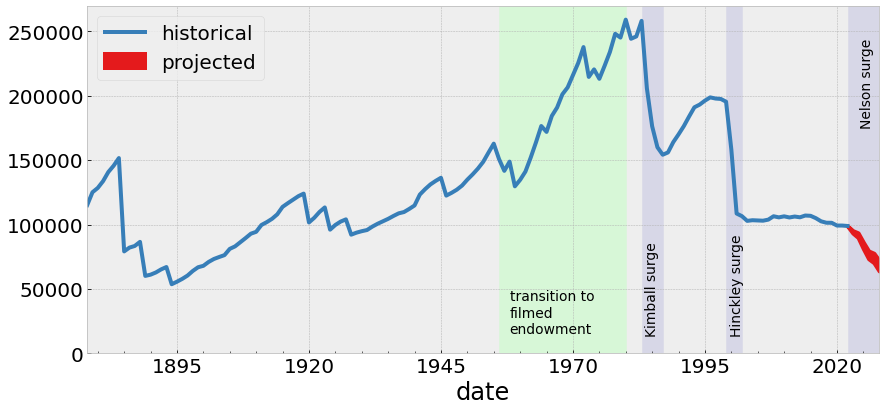

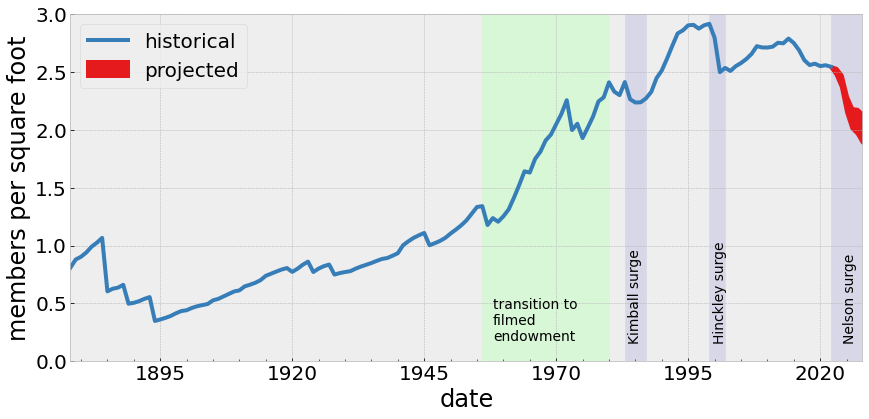

In [18]:
ax1 = m_t['historical'].plot(ylim=[0, None])
ax1.fill_between(m_t.index, m_t['projected (min)'], m_t['projected (max)'],
                 color=clist[1], lw=lw_default)
ax1.legend(['historical', 'projected'], loc='upper left')
add_bg(ax1, 'fkhn', yval=0.65)
create_ppt_slide('members_per_temple2', 'church membership per temple over time')

pl.figure()
ax2 = m_a['historical'].plot(ylabel='members per square foot', ylim=[0, 3])
ax2.fill_between(m_a.index, m_a['projected (min)'], m_a['projected (max)'],
                 color=clist[1], lw=lw_default)
ax2.legend(['historical', 'projected'], loc='upper left')
add_bg(ax2, 'fkhn')
create_ppt_slide('members_per_sq_ft2', 'church membership per square foot of temple over time')

In [19]:
# costs are per square foot and per acre
construction_cost = 1000
land_cost = 1000000

date_info = td[~td['Dedication date'].isna() & ~td['Groundbreaking date'].isna() &
               (td['Dedication date']>pd.to_datetime('1950-01-01'))][
    ['Groundbreaking date', 'Dedication date', 'area',
     'site', 'completion_estimated', 'site_estimated']]
date_info['land_purchase'] = date_info['Groundbreaking date'].dt.year - 1

date_info['years'] = date_info.apply(lambda x: range(x['Groundbreaking date'].year,
                                                     x['Dedication date'].year+1), axis=1)
date_info['area_amortized'] = date_info['area'] / date_info['years'].str.len()

years = date_info.explode('years')[['years', 'area_amortized', 'completion_estimated']]

yearly_total_ = years.groupby(['years', 'completion_estimated']).sum().reset_index().pivot(
    index='years', columns='completion_estimated').fillna(0)
yearly_total_.columns = ['area_amortized', 'area_amortized_est']

yearly_total = pd.Series(index=range(1950,2029), dtype='float64').to_frame('x').join(
    yearly_total_).drop(columns='x').fillna(0)

land_acres = date_info[['land_purchase', 'site', 'site_estimated']].groupby(
    ['land_purchase', 'site_estimated']).sum().reset_index().pivot(
    index='land_purchase', columns='site_estimated').fillna(0)
land_acres.columns = ['land', 'land_est']

yearly_total = yearly_total.join(land_acres).fillna(0)
yearly_total['land cost'] = yearly_total['land']*land_cost
yearly_total['land cost (projected)'] = yearly_total['land_est']*land_cost
yearly_total['construction cost'] = yearly_total['area_amortized']*construction_cost
yearly_total['construction cost\n(projected)'] = yearly_total['area_amortized_est']*construction_cost
yearly_total['total cost'] = yearly_total[['land cost', 'land cost (projected)',
                                           'construction cost', 'construction cost\n(projected)']].sum(1)

added ../presentation/cost_est.png to presentation


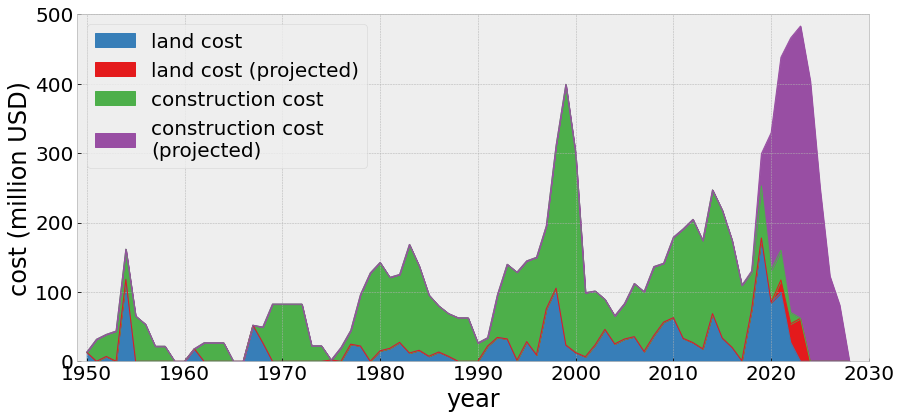

In [20]:
# stacked area graph of the 4 components of the total
ax = (yearly_total[['land cost', 'land cost (projected)',
                    'construction cost', 'construction cost\n(projected)']]/1e6).plot.area(
    stacked=True,
    ylabel='cost (million USD)',
    xlabel='year',
    xlim=[1949, 2030],
    ylim=[0, 500], lw=1)

create_ppt_slide('cost_est', 'Estimated annual expenditure on temple construction')

added ../presentation/cost_budget.png to presentation


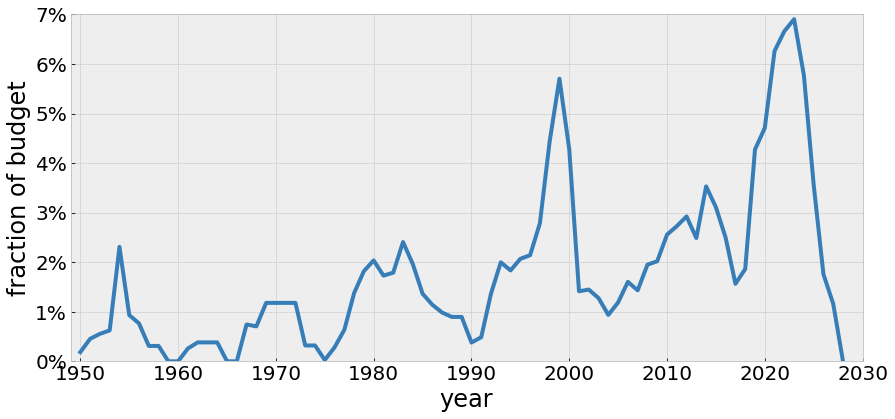

In [21]:
(yearly_total['total cost']/7e9*100).plot(
    xlabel='year',
    ylabel='fraction of budget',
    ylim=[0, 7],
    xlim=[1949, 2030])
yt = range(0, 8)
pl.yticks(yt, [str(x)+'%' for x in yt])

create_ppt_slide('cost_budget', 'Temple construction as a fraction of church operating budget')

## Discourse analysis

In [22]:
# Load the talk data
talk_data = get_only_talks(load_data())

rpm_str = 'references per million words'

# Create new date groups for 2 and 5 years at a time
talk_data['2y'] = pd.to_datetime(
    talk_data['date'].dt.year//2*20000+10101, format='%Y%m%d', utc=True)
talk_data['5y'] = pd.to_datetime(
    talk_data['date'].dt.year//5*50000+20701, format='%Y%m%d', utc=True)

def text_search_plot(search, title_str, leg_loc=None, spacer=' ', group='2y', filename=None):
    if 'top_user' not in search.keys():
        search.update({'top_user': 'false'})
    result = text_search(talk_data, search, group=group, spacer=spacer, quiet=True)
    fig, ax = pl.subplots()
    result.plot(ax=ax, legend=False, title=title_str, ylabel=rpm_str, xlabel='year')
    pl.legend(result.columns, loc=leg_loc)
    #pl.grid(axis='x')
    #ax.set_xlim(daterange)
    ax.set_ylim(bottom=0)
    if filename!=None:
        pl.savefig(filename)

loading ../conference_data.pkl


added ../presentation/gc_temple.png to presentation


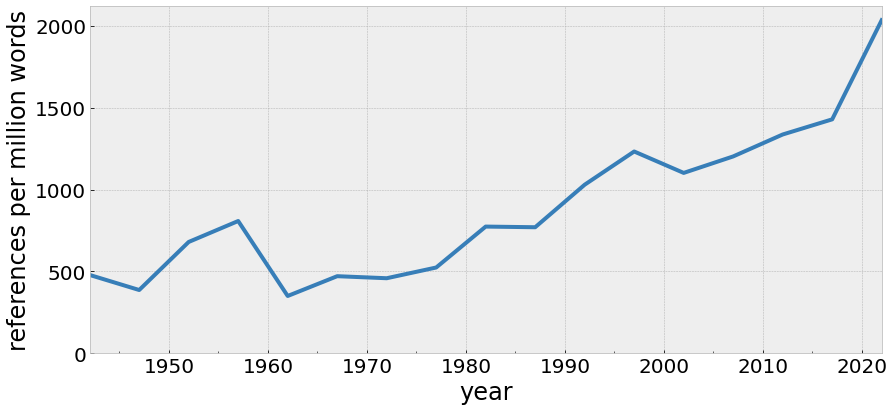

In [23]:
text_search_plot(
    {'search': [{"include": "temple"}]}, '', group='5y')
pl.gca().get_legend().remove()

create_ppt_slide('gc_temple', 'References to "temple" in general conference')

added ../presentation/genealogy.png to presentation


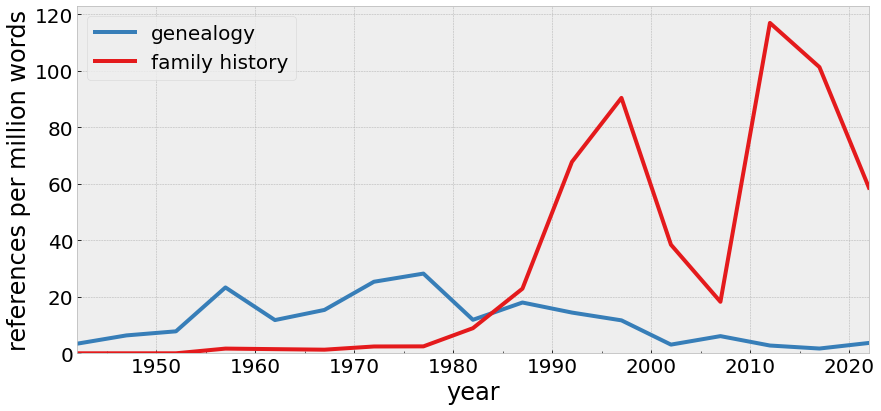

In [24]:
text_search_plot(
    {'search': [
        {"include": "genealogy"},
        {"include": "family history"}]}, '', group='5y')
create_ppt_slide('genealogy', 'references to genealogy/family history')

added ../presentation/temple_words1.png to presentation
added ../presentation/temple_words2.png to presentation
added ../presentation/temple_words3.png to presentation


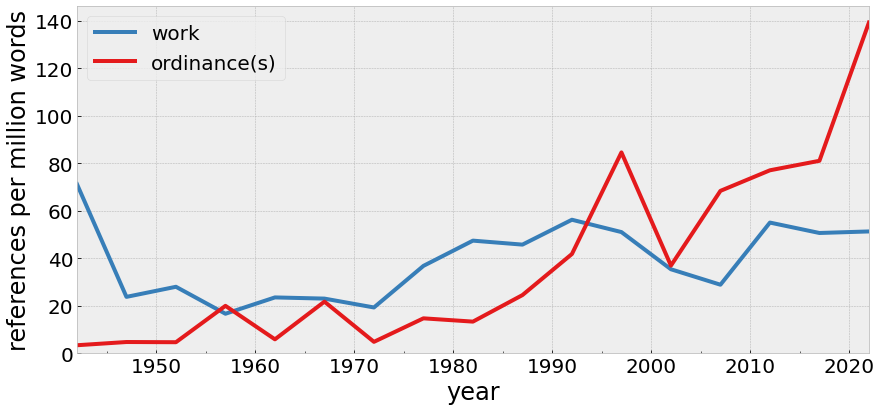

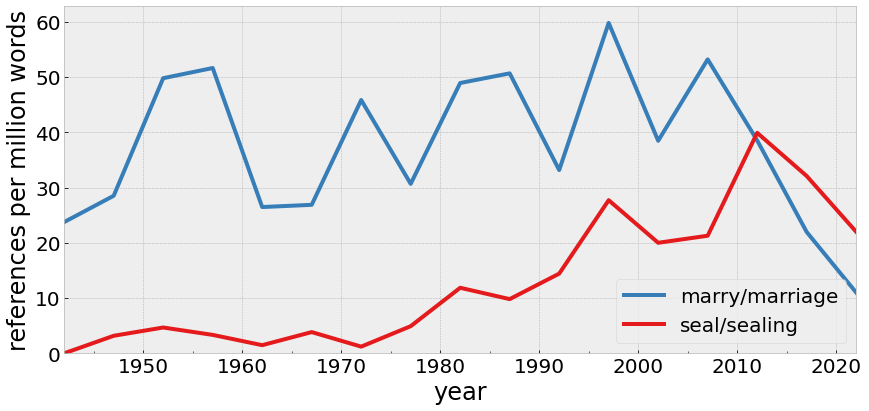

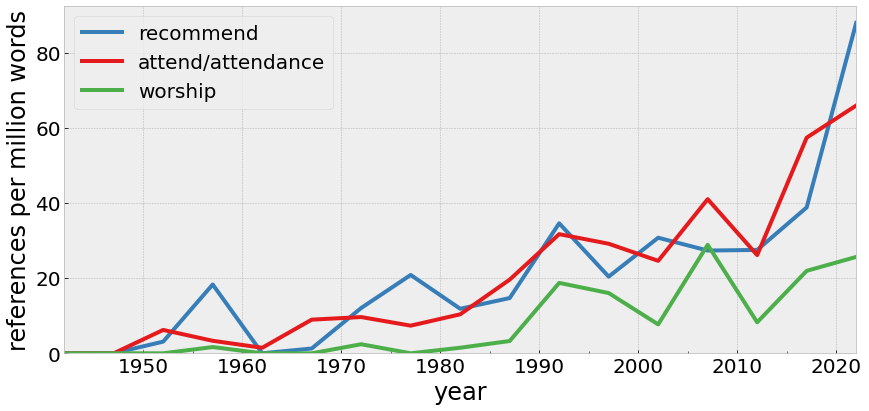

In [25]:
text_search_plot(
    {'search': [
        {"label": "work",
         "include": "(work[^,.]{,15}[^,.]temple|temple work)"},
        {"label": "ordinance(s)",
         "include": "(ordinance[^,.]{,15}[^,.]temple|temple ordinance)"}
    ]}, '', group='5y')
create_ppt_slide('temple_words1', '"work" vs. "ordinances"')

text_search_plot(
    {'search': [
        {"label": "marry/marriage",
         "include": "((marry|married|marriage)[^,.]{,15}[^,.]temple|temple marriage)"},
        {"label": "seal/sealing",
         "include": "((seal)[^,.]{,15}[^,.]temple|temple seal)"}
    ]}, '', group='5y')
create_ppt_slide('temple_words2', '"marriage" vs. "sealing"')

text_search_plot(
    {'search': [
        {"label": "recommend",
         "include": "(recommend[^,.]{,15}[^,.]temple|temple recommend)"},
        {"label": "attend/attendance",
         "include": "(attend[^,.]{,15}[^,.]temple|temple attendance)"},
        {"label": "worship",
         "include": "(worship[^,.]{,15}[^,.]temple|temple worship)"}
    ]}, '', group='5y')
create_ppt_slide('temple_words3', 'the temple as worship')

added ../presentation/checklist.png to presentation
added ../presentation/checklist_plus_temple.png to presentation


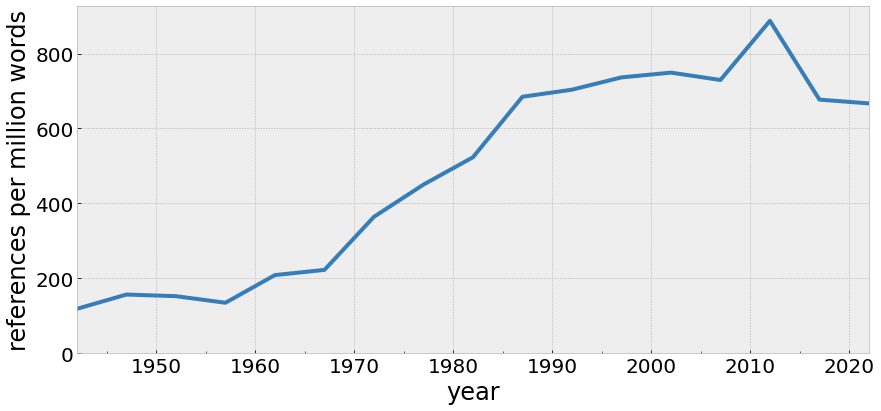

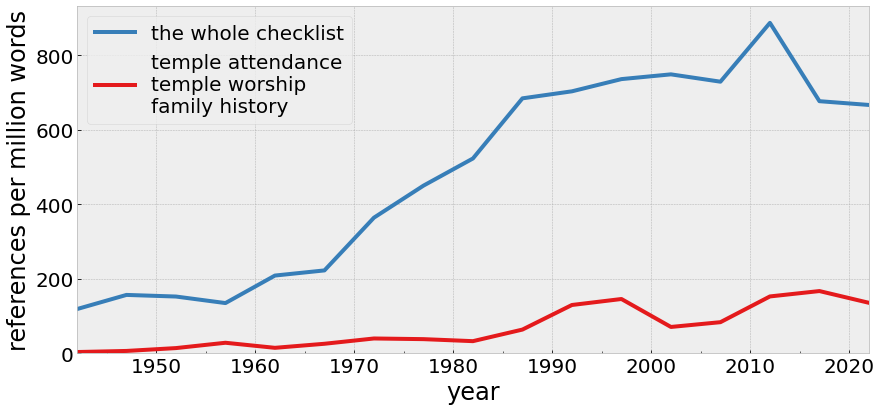

In [26]:
big_list = [
    {"label": "missionary service",
     "include": "(serv(e|i)[^.]{,20} mission[^a]|(go|going|went|called) on a mission|missionary service)"},
    {"label": "scripture study",
     "include": "(scripture study|scripture reading|study[^.,]{,15}scriptures|read[^.,]{,12}scriptures)"},
    {"label": "temple/family history",
     "include": "(attend[^,.]{,15}[^,.]temple|temple attendance|temple worship|"
     "family history|genealogy)"},
    {"label": "home & visiting teaching",
     "include": "((home|visiting) teaching|ministering (to|as|and|brother|sister))"},
    {"label": "prayer",
     "include": "(personal|family|daily) prayer"},
    {"label": "Family Home Evening",
     "include": "family home evening"},
    {"label": "youth awards",
     "include": "(eagle scout|eagle rank|eagle award|duty to god (award|requirements|service|booklet|program)|young womanhood (recognition|medallion))"}
]

text_search_plot(
    {'search': [{'label': '', 'include': '('+'|'.join([x['include'] for x in big_list])+')'}]},
    '', group='5y')
pl.gca().get_legend().remove()
create_ppt_slide('checklist', 'the rise of the "Mormon checklist"')

text_search_plot(
    {'search': [{'label': 'the whole checklist', 'include': '('+'|'.join([x['include'] for x in big_list])+')'},
                {"label": "temple attendance\ntemple worship\nfamily history",
                 "include": "(attend[^,.]{,15}[^,.]temple|temple attendance|temple worship|"
                 "family history|genealogy)"}
               ]}, '', group='5y')
create_ppt_slide('checklist_plus_temple', 'temple attendance and the rest of the checklist')

In [27]:
pres.save('../presentation/sunstone22_charts.pptx')